In [1]:
# 適宜自分のApplicationPATHまで変更
APP_PATH = '/root'
# APP_PATH = '.'


# 標準モジュール(install不要)
import os
import random

# import time
# import copy
# from collections import defaultdict
import torch
# import shutil
# import pandas as pd
from skimage import io, transform # scikit-image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils # 現時点では使ってない
from torch import nn
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
# import zipfile


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = APP_PATH + '/data/img'
CHECKPOINT_PATH = APP_PATH + '/data/model'
CHECKPOINT_PATH_UNet = CHECKPOINT_PATH + '/UNet'

# os.chdir(APP_PATH)

In [2]:
# ファイルの実行(ノートブック側でランタイムの再接続 or reloadをする)
# importで実行するときはファイルのパスを通す必要がある
# sys.path.append(APP_PATH + '/bin')

# setupなどのOSに関するコマンド実行はその定義ファイルをコマンドで実行
# 関数などのモジュールはimportで扱えるようにして実行
# !python bin/setup.py

# はじめから256にresizeされている
IMG_HEIGHT = 256
IMG_WIDTH = 256

NUM_EPOCHS = 60

In [3]:
#画像データ拡張の関数
def get_train_transform():
    
   return alb.Compose(
       [
        #リサイズ(元画像ですでにしているが)
        alb.Resize(IMG_HEIGHT, IMG_WIDTH),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        alb.HorizontalFlip(p=0.25),
        #垂直フリップ
        alb.VerticalFlip(p=0.25),
        ToTensorV2(),
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self, path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self, idx):
            image_folder = os.path.join(self.path, self.folders[idx], 'images/')
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
            image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
            
            # debug
            # print(f'image_folder: {image_folder}')
            # print(f'mask_folder: {mask_folder}')
            # print(f'image_path: {image_path}')
            # print(f'mask_path: {mask_path}')
            
            #画像データの取得
            # 3次元の処理を2次元に変更するのがいろいろめんどくさいから3次元の型で扱うことにする
            ## exec img
            # img = io.imread(image_path)[:,:,:3].astype('float32')
            img = io.imread(image_path)
            # TODO: 正答率がでたら比較としてfloat32でも試してみる
            # print(f'2d img.shape: {img.shape}') # 白黒なのでチャネル数が省略されて2次元データになっている
            img = self.conv_2D_to_3Darray(img)
            # print(f'3d img.shape: {img.shape}')


            ## exec mask
            # img = transform.resize(img,(256,256))
            ## mask = io.imread(mask_path)
            # maskの量が2つ以上になったらここの関数を実行してすべてを得る
            # mask = self.get_mask(mask_folder, 256, 256).astype('float32')
            mask = self.get_mask(mask_folder, IMG_HEIGHT, IMG_WIDTH) # nint8でOK?
            # print(f'calced mask.shape: {mask.shape}')

            # 前処理をするためにひとつにまとめる
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return (img,mask)
        
        def conv_2D_to_3Darray(self, arr):
            # print(f'exec conv_2D_to_3Darray')
            image = Image.fromarray(arr)
            image = image.convert("RGB")
            # 変換するならここでfloat32にする
            arr = np.asarray(image, np.uint8)
            # print(f'to3d arr shape: {arr.shape}')
            return arr

        def conv_3D_to_2Darray(self, arr):
            # print(f'exec conv_3D_to_2Darray')
            image = Image.fromarray(arr)
            image = image.convert("L")
            arr = np.asarray(image, np.uint8) # 変換するならここでfloat32にする
            # print(f'to2d arr shape: {arr.shape}')
            # arr = np.transpose(arr, (2, 0, 1))
            # print(f'arr transpose shape: {arr.shape}')
            return arr

        #マスクデータの取得
        def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            # print(f'len(os.listdir(mask_folder)): {len(os.listdir(mask_folder))}')
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    # RGBからLへ
                    mask_ = self.conv_3D_to_2Darray(mask_)
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

# データセットを確認する
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())


# 辞書型のときに要素を取得するマジックメソッド　以下と同じ意味
# image, mask = train_dataset.__getitem__(0)
image, mask = train_dataset[0]
print(image.shape)
print(mask.shape)

#Print total number of unique images.
# フォルダーの長さを表示　以下と同じ意味
train_dataset.__len__()
print(len(train_dataset))


torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
60


[8, 49, 3]


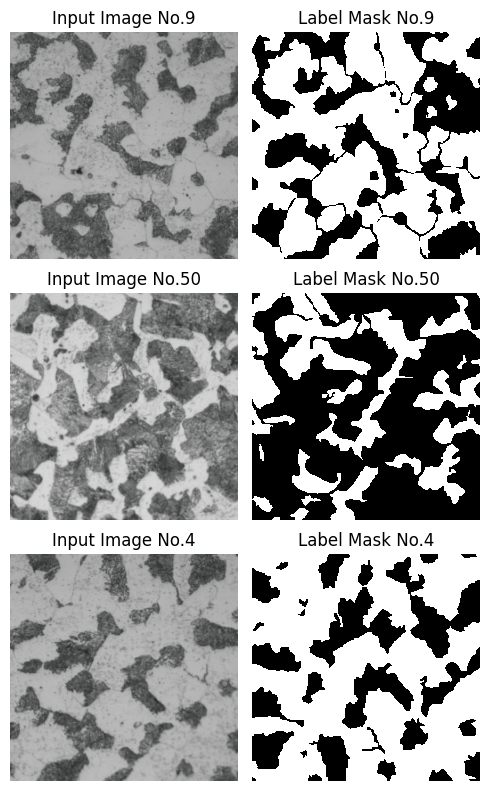

In [4]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, num_range, predict=None):
    #TODO:表示時に水平・垂直クリップがかるからかからないようにする(Predictedのほうも)
    images = random.sample(range(0, num_range), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset[i]
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

num_range = len(train_dataset)
visualize_dataset(3, num_range)

In [5]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 45
Length of validation　data: 15


In [6]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込みとバッチ正規化と活性化関数Reluをまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )



In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice


In [8]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [9]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()

valid_loss_min = np.Inf

best_model_file = '/best_model.pth'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(NUM_EPOCHS):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    ## 容量をとるので必要になったら保存する
    # checkpoint_file = "/checkpoint_{}_weight.pth".format(epoch+1)
    # checkpointの保存
    # torch.save(checkpoint, CHECKPOINT_PATH_UNet + checkpoint_file)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        torch.save(checkpoint, CHECKPOINT_PATH_UNet + best_model_file)
        valid_loss_min = total_valid_loss[-1]

    print("")
    


Epoch: 1, loss: 0.1274127761221472, IoU: 0.7739737230783038: 100%|█| 5/5 [0


Train Loss: 0.1696561175102584, Train IOU: 0.7241294351240717
Valid Loss: 0.10619272048392886, Valid IOU: 0.8101539319016205
Validation loss decreased (inf --> 0.106193).  Saving model ...



Epoch: 2, loss: 0.0465450458099026, IoU: 0.9110502756683969: 100%|█| 5/5 [0


Train Loss: 0.07440844389610893, Train IOU: 0.862094428274888
Valid Loss: 0.1026942280719324, Valid IOU: 0.8154666776444754
Validation loss decreased (0.106193 --> 0.102694).  Saving model ...



Epoch: 3, loss: 0.1537205051235192, IoU: 0.7335228337973366: 100%|█| 5/5 [0


Train Loss: 0.08339445242672702, Train IOU: 0.84874200723149
Valid Loss: 0.09058236454885599, Valid IOU: 0.8344327863838484
Validation loss decreased (0.102694 --> 0.090582).  Saving model ...



Epoch: 4, loss: 0.07060980923247684, IoU: 0.8680945587859197: 100%|█| 5/5 [


Train Loss: 0.07206726234516543, Train IOU: 0.8656767225851475
Valid Loss: 0.08652638029244436, Valid IOU: 0.8424609473967339
Validation loss decreased (0.090582 --> 0.086526).  Saving model ...



Epoch: 5, loss: 0.06932804353788502, IoU: 0.8703337608532022: 100%|█| 5/5 [


Train Loss: 0.06062023842644637, Train IOU: 0.8859089409090405
Valid Loss: 0.07977805377222719, Valid IOU: 0.8535112079270255
Validation loss decreased (0.086526 --> 0.079778).  Saving model ...



Epoch: 6, loss: 0.08135854995352798, IoU: 0.8495257482111487: 100%|█| 5/5 [


Train Loss: 0.06435702134727797, Train IOU: 0.8792139423196133
Valid Loss: 0.08706815699266585, Valid IOU: 0.8424534279052562



Epoch: 7, loss: 0.09885216794898088, IoU: 0.8200814655081208: 100%|█| 5/5 [


Train Loss: 0.060759547062391686, Train IOU: 0.8861294622826069
Valid Loss: 0.07373729091468328, Valid IOU: 0.8632038079501414
Validation loss decreased (0.079778 --> 0.073737).  Saving model ...



Epoch: 8, loss: 0.03524211332887672, IoU: 0.9319153361447838: 100%|█| 5/5 [


Train Loss: 0.053488459953202484, Train IOU: 0.898643631184888
Valid Loss: 0.06993641116414373, Valid IOU: 0.8703308857391095
Validation loss decreased (0.073737 --> 0.069936).  Saving model ...



Epoch: 9, loss: 0.0848935839094428, IoU: 0.8434990686303899: 100%|█| 5/5 [0


Train Loss: 0.06295517882318565, Train IOU: 0.8819515171184346
Valid Loss: 0.0713580516502495, Valid IOU: 0.868352863685713



Epoch: 10, loss: 0.07010953128721764, IoU: 0.8689679265977223: 100%|█| 5/5 


Train Loss: 0.05910971200415467, Train IOU: 0.8890803754612066
Valid Loss: 0.0776176046201208, Valid IOU: 0.8574248160544389



Epoch: 11, loss: 0.04112900345433779, IoU: 0.9209917910681299: 100%|█| 5/5 


Train Loss: 0.059319224280269076, Train IOU: 0.8884710320527942
Valid Loss: 0.0687955547797155, Valid IOU: 0.8719713495760868
Validation loss decreased (0.069936 --> 0.068796).  Saving model ...



Epoch: 12, loss: 0.04545334557650693, IoU: 0.9130458598933449: 100%|█| 5/5 


Train Loss: 0.05791634193006838, Train IOU: 0.8908294747262158
Valid Loss: 0.06973226505030466, Valid IOU: 0.8704331213460923



Epoch: 13, loss: 0.0478463526478804, IoU: 0.9086769562950626: 100%|█| 5/5 [


Train Loss: 0.05686757889846379, Train IOU: 0.892807331118485
Valid Loss: 0.06284314870777602, Valid IOU: 0.8823168363554338
Validation loss decreased (0.068796 --> 0.062843).  Saving model ...



Epoch: 14, loss: 0.05676092425616208, IoU: 0.8925758900070929: 100%|█| 5/5 


Train Loss: 0.054228952254823604, Train IOU: 0.8972498593243984
Valid Loss: 0.0638450907636437, Valid IOU: 0.880780153836502



Epoch: 15, loss: 0.044179166361676736, IoU: 0.9153802916595852: 100%|█| 5/5


Train Loss: 0.053296867276756685, Train IOU: 0.8989796749403652
Valid Loss: 0.059556800452180314, Valid IOU: 0.8882509656371451
Validation loss decreased (0.062843 --> 0.059557).  Saving model ...



Epoch: 16, loss: 0.04906067221427435, IoU: 0.9064676668073572: 100%|█| 5/5 


Train Loss: 0.050580430405792895, Train IOU: 0.9037916275231781
Valid Loss: 0.06993990438163034, Valid IOU: 0.8704871326658981



Epoch: 17, loss: 0.048068502916491784, IoU: 0.9082724487411528: 100%|█| 5/5


Train Loss: 0.05598343252186877, Train IOU: 0.8943031823951632
Valid Loss: 0.060391758567583664, Valid IOU: 0.8868821107801417



Epoch: 18, loss: 0.04911466293590416, IoU: 0.906369620372573: 100%|█| 5/5 [


Train Loss: 0.05400456078753293, Train IOU: 0.8978460704201483
Valid Loss: 0.05621499309285205, Valid IOU: 0.893961352728434
Validation loss decreased (0.059557 --> 0.056215).  Saving model ...



Epoch: 19, loss: 0.045237372944135434, IoU: 0.9134412409014782: 100%|█| 5/5


Train Loss: 0.05035008601489917, Train IOU: 0.904218550462236
Valid Loss: 0.062491708362239884, Valid IOU: 0.8825854732723439



Epoch: 20, loss: 0.04731185070194499, IoU: 0.9096511299601466: 100%|█| 5/5 


Train Loss: 0.049352008416970336, Train IOU: 0.9059901433900389
Valid Loss: 0.06145599239368027, Valid IOU: 0.8845477787709186



Epoch: 21, loss: 0.07073215225177432, IoU: 0.8678811221374665: 100%|█| 5/5 


Train Loss: 0.05373511471268042, Train IOU: 0.8983109989077338
Valid Loss: 0.05585456922179194, Valid IOU: 0.8946454508378954
Validation loss decreased (0.056215 --> 0.055855).  Saving model ...



Epoch: 22, loss: 0.11864864219808058, IoU: 0.7878719077495515: 100%|█| 5/5 


Train Loss: 0.07210463261561806, Train IOU: 0.866884717617084
Valid Loss: 0.06230587139020194, Valid IOU: 0.8833131007598435



Epoch: 23, loss: 0.03665366305766338, IoU: 0.9292847924854942: 100%|█| 5/5 


Train Loss: 0.06657504389899745, Train IOU: 0.8769920584483881
Valid Loss: 0.09904133485489292, Valid IOU: 0.8223338106915508



Epoch: 24, loss: 0.08526591519440374, IoU: 0.8428666867203646: 100%|█| 5/5 


Train Loss: 0.0712889972191915, Train IOU: 0.867478698012951
Valid Loss: 0.08934042443144846, Valid IOU: 0.8372814114072997



Epoch: 25, loss: 0.11814187044477797, IoU: 0.7886824121276323: 100%|█| 5/5 


Train Loss: 0.07139861049424764, Train IOU: 0.8676830301504346
Valid Loss: 0.08615735012097542, Valid IOU: 0.8430570896241745



Epoch: 26, loss: 0.04256340971596517, IoU: 0.9183487512641149: 100%|█| 5/5 


Train Loss: 0.058115229118843835, Train IOU: 0.8904639234228224
Valid Loss: 0.0754748340711997, Valid IOU: 0.8606260810487565



Epoch: 27, loss: 0.06855422555304536, IoU: 0.8716882790322199: 100%|█| 5/5 


Train Loss: 0.05955820265826517, Train IOU: 0.8878696563756956
Valid Loss: 0.06650160953596096, Valid IOU: 0.8761362484410276



Epoch: 28, loss: 0.09384020070496601, IoU: 0.8284210833942081: 100%|█| 5/5 


Train Loss: 0.0590372507188033, Train IOU: 0.8892773961197531
Valid Loss: 0.06341831419194255, Valid IOU: 0.880895422155654



Epoch: 29, loss: 0.05766291906065801, IoU: 0.8909618757258182: 100%|█| 5/5 


Train Loss: 0.05462638421980095, Train IOU: 0.8964555871211546
Valid Loss: 0.060181997109768404, Valid IOU: 0.8871377572619995



Epoch: 30, loss: 0.04291368676989915, IoU: 0.9177044472087318: 100%|█| 5/5 


Train Loss: 0.05170733530947376, Train IOU: 0.901803775852318
Valid Loss: 0.06469555633273055, Valid IOU: 0.8792397800943961



Epoch: 31, loss: 0.04441953619251926, IoU: 0.9149395116107462: 100%|█| 5/5 


Train Loss: 0.05165389921496799, Train IOU: 0.9022480345026468
Valid Loss: 0.06255020836796732, Valid IOU: 0.8827229768846165



Epoch: 32, loss: 0.037259467310340466, IoU: 0.9281580652461077: 100%|█| 5/5


Train Loss: 0.05046608983470009, Train IOU: 0.9040316676456424
Valid Loss: 0.06930342650445492, Valid IOU: 0.8713618687283466



Epoch: 33, loss: 0.05941269652996095, IoU: 0.8878386824277893: 100%|█| 5/5 


Train Loss: 0.053527211401372066, Train IOU: 0.8988191107818206
Valid Loss: 0.06057573978006181, Valid IOU: 0.886239168755205



Epoch: 34, loss: 0.029785224325715398, IoU: 0.9421526524370488: 100%|█| 5/5


Train Loss: 0.05373356567945133, Train IOU: 0.8986978843774315
Valid Loss: 0.05440402485278384, Valid IOU: 0.897190352817884
Validation loss decreased (0.055855 --> 0.054404).  Saving model ...



Epoch: 35, loss: 0.07751421734186648, IoU: 0.8561243107301197: 100%|█| 5/5 


Train Loss: 0.052971664227531724, Train IOU: 0.8996450475976971
Valid Loss: 0.056646539907227345, Valid IOU: 0.8933576020896403



Epoch: 36, loss: 0.03221778361205574, IoU: 0.9375757606619048: 100%|█| 5/5 


Train Loss: 0.049201843556513844, Train IOU: 0.9065149840302894
Valid Loss: 0.05923435356070117, Valid IOU: 0.8889935283723824



Epoch: 37, loss: 0.03810515955854499, IoU: 0.926587290851674: 100%|█| 5/5 [


Train Loss: 0.0467509223880862, Train IOU: 0.9107988187525932
Valid Loss: 0.05646278821027162, Valid IOU: 0.8937428709169464



Epoch: 38, loss: 0.05785451960012944, IoU: 0.8906194206393541: 100%|█| 5/5 


Train Loss: 0.053791626423654426, Train IOU: 0.8984194701241878
Valid Loss: 0.058120615769040096, Valid IOU: 0.8906737873540445



Epoch: 39, loss: 0.09729665618211691, IoU: 0.8226615125960045: 100%|█| 5/5 


Train Loss: 0.06064331112975163, Train IOU: 0.886298556802112
Valid Loss: 0.054584644854116404, Valid IOU: 0.8969083367594993



Epoch: 40, loss: 0.06888367640226556, IoU: 0.8711113697557415: 100%|█| 5/5 


Train Loss: 0.052816690013295475, Train IOU: 0.8998485972430817
Valid Loss: 0.07686164323330619, Valid IOU: 0.8589688197879218



Epoch: 41, loss: 0.14409505255466548, IoU: 0.7481072502754935: 100%|█| 5/5 


Train Loss: 0.06775813742664256, Train IOU: 0.8755098955795573
Valid Loss: 0.06406169699408687, Valid IOU: 0.8800205830589305



Epoch: 42, loss: 0.14936781166823354, IoU: 0.7400878828242358: 100%|█| 5/5 


Train Loss: 0.06879092904331045, Train IOU: 0.8738035439478992
Valid Loss: 0.06199354902283338, Valid IOU: 0.8833162410421844



Epoch: 43, loss: 0.0780084671927801, IoU: 0.8552734145480508: 100%|█| 5/5 [


Train Loss: 0.05798600298693253, Train IOU: 0.8909850494240816
Valid Loss: 0.056060625573829126, Valid IOU: 0.8941656859169007



Epoch: 44, loss: 0.028530147232140757, IoU: 0.9445226409877903: 100%|█| 5/5


Train Loss: 0.04890118283789655, Train IOU: 0.9071250555922218
Valid Loss: 0.05526421548333055, Valid IOU: 0.895462695707027



Epoch: 45, loss: 0.0664074513585875, IoU: 0.875456050838769: 100%|█| 5/5 [0


Train Loss: 0.05671825699892006, Train IOU: 0.89288122520705
Valid Loss: 0.05609646571224941, Valid IOU: 0.8941508196824846



Epoch: 46, loss: 0.0669934572554447, IoU: 0.8744260266470572: 100%|█| 5/5 [


Train Loss: 0.05845094772939674, Train IOU: 0.8905778519496128
Valid Loss: 0.05930306144217723, Valid IOU: 0.8883795694434115



Epoch: 47, loss: 0.04506342850779499, IoU: 0.9137595896008233: 100%|█| 5/5 


Train Loss: 0.051349576826455266, Train IOU: 0.9024650492170364
Valid Loss: 0.05354139669936675, Valid IOU: 0.8986038435013461
Validation loss decreased (0.054404 --> 0.053541).  Saving model ...



Epoch: 48, loss: 0.11552889839329217, IoU: 0.7928721589192764: 100%|█| 5/5 


Train Loss: 0.05788617983000195, Train IOU: 0.8919626282575221
Valid Loss: 0.053102014517024954, Valid IOU: 0.8995224095614462
Validation loss decreased (0.053541 --> 0.053102).  Saving model ...



Epoch: 49, loss: 0.05338938912290936, IoU: 0.8986333236725731: 100%|█| 5/5 


Train Loss: 0.0497996822839875, Train IOU: 0.9052731722657189
Valid Loss: 0.05484205555242766, Valid IOU: 0.8961983434126077



Epoch: 50, loss: 0.0557576358061711, IoU: 0.8943743622112736: 100%|█| 5/5 [


Train Loss: 0.0515910436101251, Train IOU: 0.9019450137741568
Valid Loss: 0.055810317999165804, Valid IOU: 0.8947639472336029



Epoch: 51, loss: 0.07178001433381509, IoU: 0.8660549093354666: 100%|█| 5/5 


Train Loss: 0.05307722842792002, Train IOU: 0.8995641845016319
Valid Loss: 0.05572577356888775, Valid IOU: 0.8947259985817516



Epoch: 52, loss: 0.07346685339747172, IoU: 0.8631225827646453: 100%|█| 5/5 


Train Loss: 0.05249028465274737, Train IOU: 0.900581796022052
Valid Loss: 0.05701814940480876, Valid IOU: 0.8922940129600375



Epoch: 53, loss: 0.04885265518010029, IoU: 0.9068458032391926: 100%|█| 5/5 


Train Loss: 0.053901421567769295, Train IOU: 0.8988051997834903
Valid Loss: 0.05178107487949407, Valid IOU: 0.9018186292136297
Validation loss decreased (0.053102 --> 0.051781).  Saving model ...



Epoch: 54, loss: 0.04641810776189892, IoU: 0.911282072236354: 100%|█| 5/5 [


Train Loss: 0.04907767099282434, Train IOU: 0.9064682836709483
Valid Loss: 0.054135554461267776, Valid IOU: 0.8975508276678186



Epoch: 55, loss: 0.07026108078572812, IoU: 0.8687032633242132: 100%|█| 5/5 


Train Loss: 0.05203448422821566, Train IOU: 0.9015789211293267
Valid Loss: 0.05408531600890565, Valid IOU: 0.8976014034715696



Epoch: 56, loss: 0.05145217309442418, IoU: 0.9021313716429891: 100%|█| 5/5 


Train Loss: 0.04798005383617206, Train IOU: 0.9087182078804791
Valid Loss: 0.05208877776016174, Valid IOU: 0.9012974633785403



Epoch: 57, loss: 0.08928406096997366, IoU: 0.8360686338626685: 100%|█| 5/5 


Train Loss: 0.05779919160652782, Train IOU: 0.8911743195971908
Valid Loss: 0.05065499356068559, Valid IOU: 0.9038955114929884
Validation loss decreased (0.051781 --> 0.050655).  Saving model ...



Epoch: 58, loss: 0.0754009898636604, IoU: 0.8597717326083074: 100%|█| 5/5 [


Train Loss: 0.05347769285322936, Train IOU: 0.8989987327613177
Valid Loss: 0.05874552618035317, Valid IOU: 0.8893493940159707



Epoch: 59, loss: 0.04442331800580579, IoU: 0.9149325377995974: 100%|█| 5/5 


Train Loss: 0.05136922445807224, Train IOU: 0.9025405470975718
Valid Loss: 0.061188987256429406, Valid IOU: 0.8848809699694126



Epoch: 60, loss: 0.04962189381940685, IoU: 0.9054482913332275: 100%|█| 5/5 


Train Loss: 0.05040082394289809, Train IOU: 0.9042154577995538
Valid Loss: 0.05899254304364959, Valid IOU: 0.8887927666733699



<Figure size 640x480 with 0 Axes>

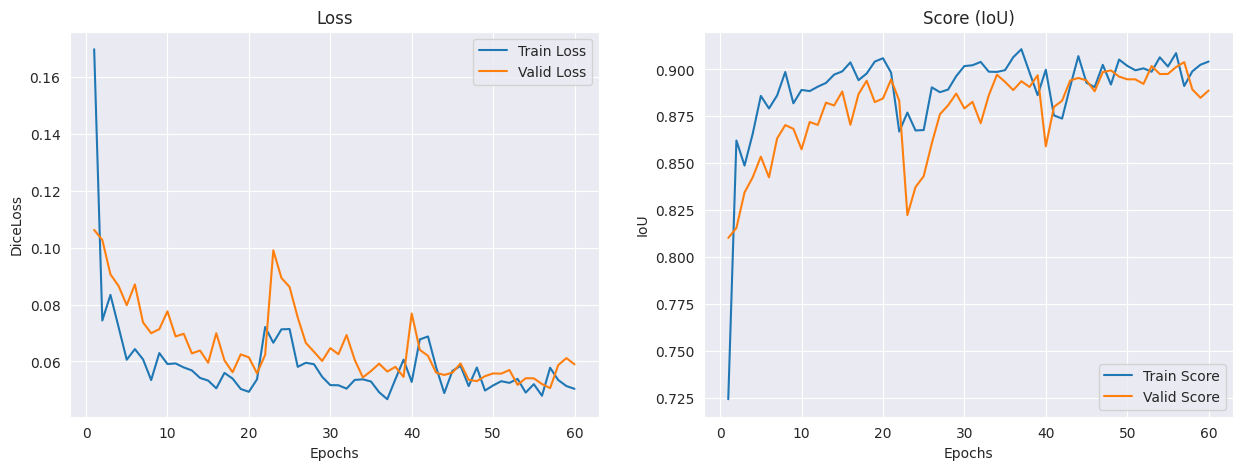

In [10]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

In [11]:
# bestmodelの読み込み
checkpoint = torch.load(CHECKPOINT_PATH_UNet + best_model_file)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']

[7, 54, 16, 17, 43, 6]


/tmp/ipykernel_1879/2669564127.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
/tmp/ipykernel_1879/2669564127.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


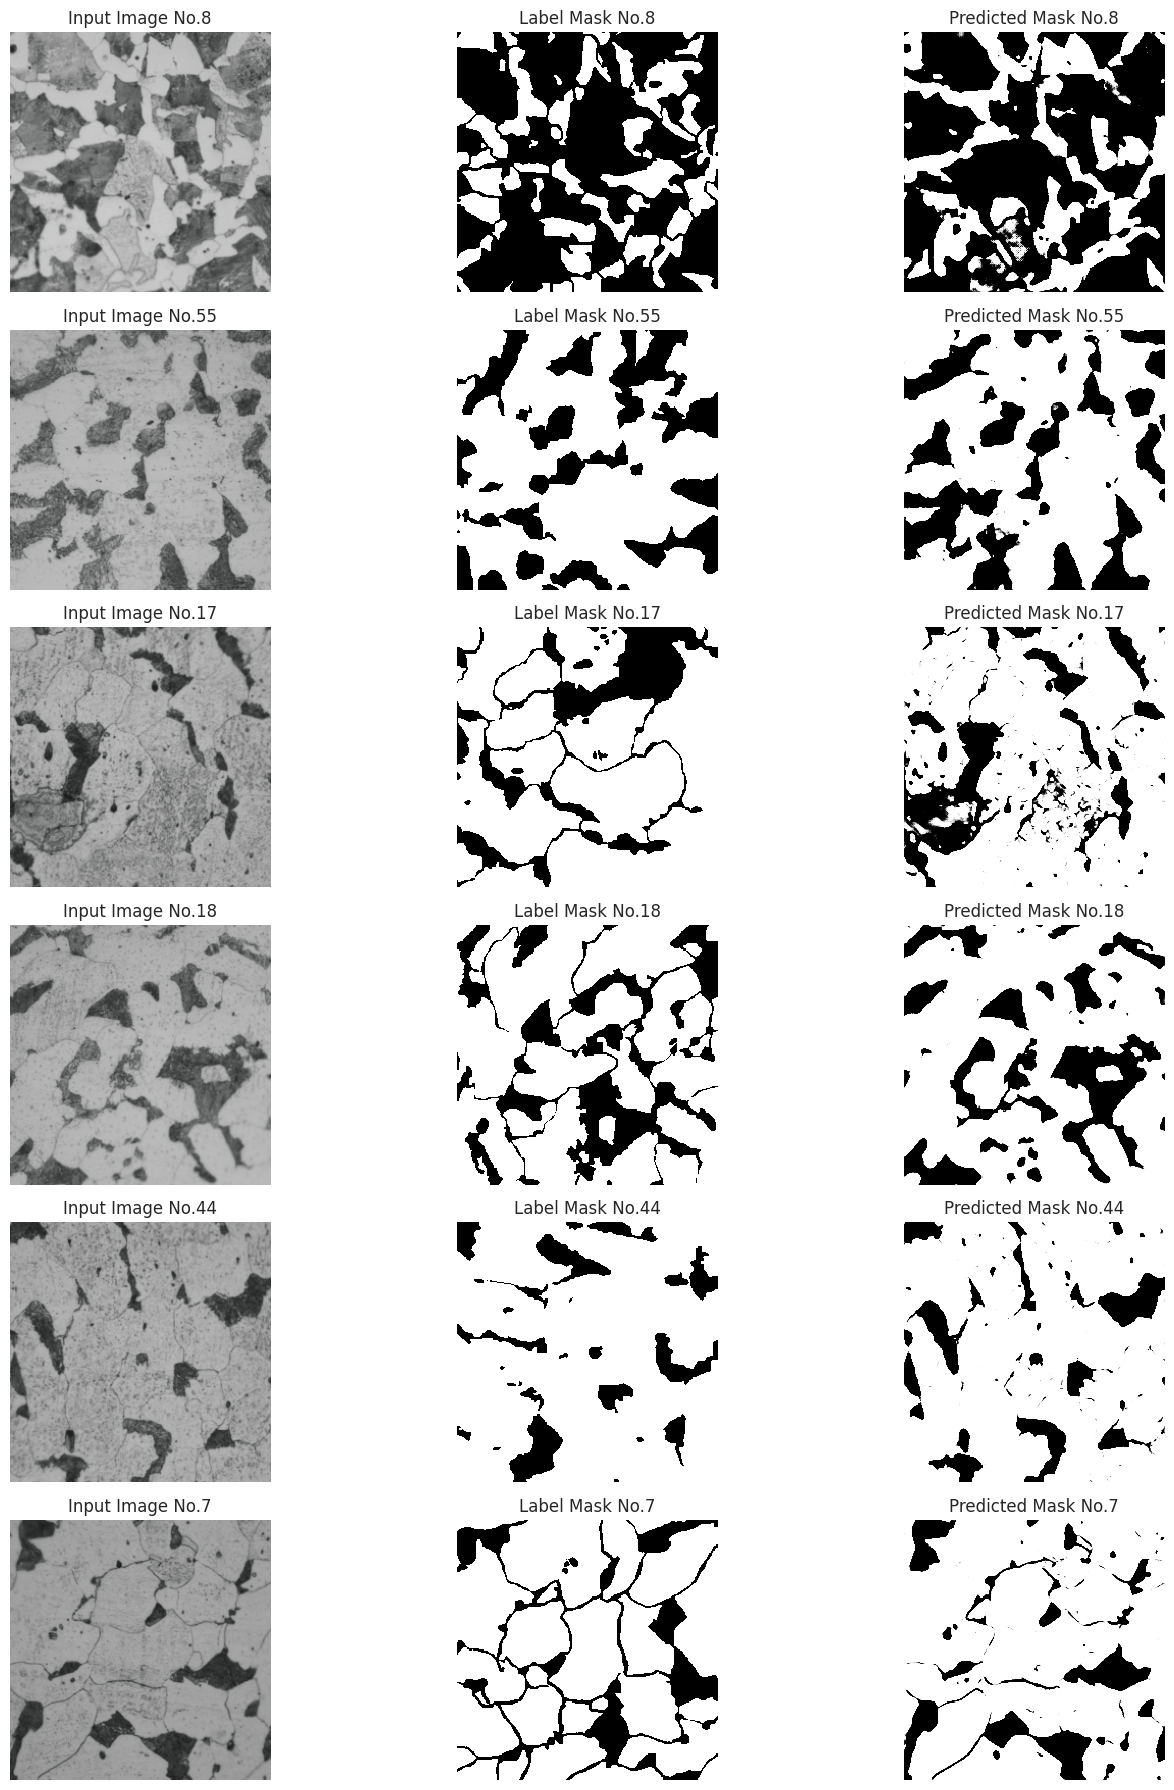

In [12]:
def visualize_predict(model, n_images, num_range):
    images = random.sample(range(0, num_range), n_images)
    print(images)
    # figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    figure, ax = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 18))
    
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            o = model(data)
            break
    for i in range(0, len(images)):
        img_no = images[i]
        tm=o[i][0].data.cpu().numpy()
        img = data[i].data.cpu()
        msk = mask[i].data.cpu()
        img = format_image(img)
        msk = format_mask(msk)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[i, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 2].set_title(f"Predicted Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6, num_range)